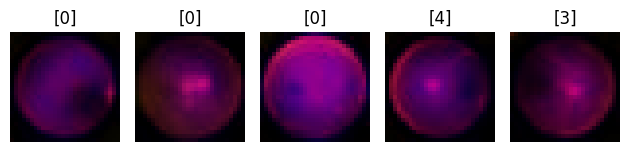

[486 128 206 194  66]


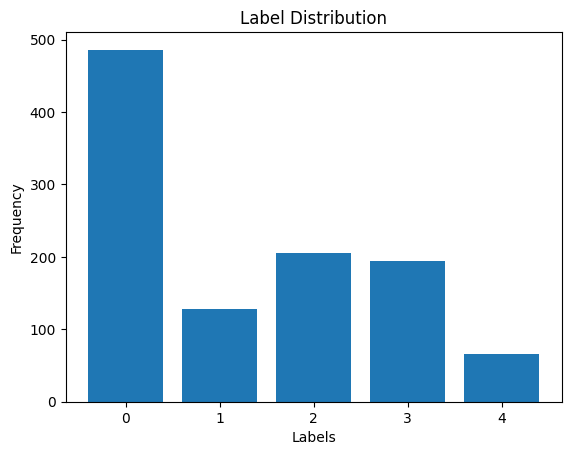

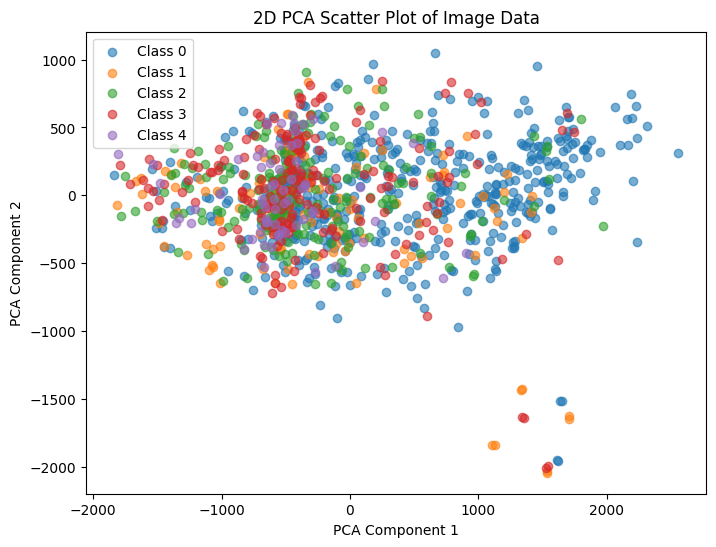

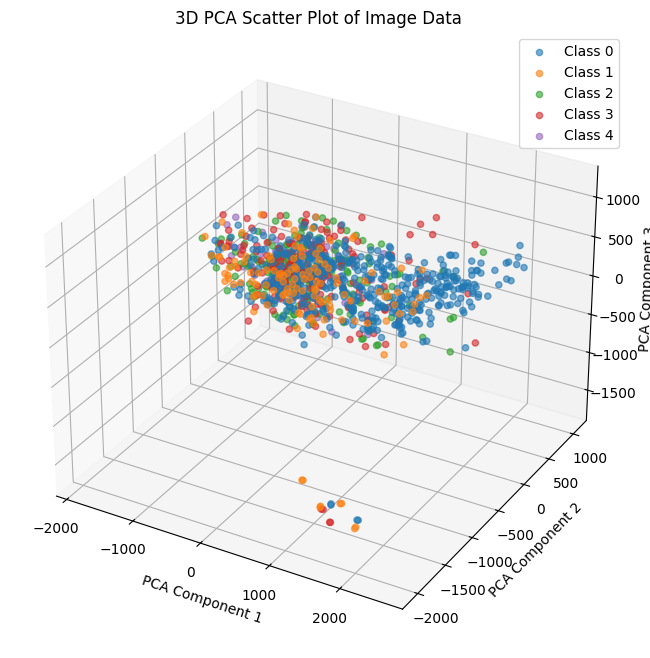

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt




# Load the data
with open('data/train_data.pkl', 'rb') as f:
    data = pickle.load(f)

images = data['images']
labels = data['labels']

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])   
    plt.title(f"{labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

unique_labels = np.unique(labels, return_counts=True)
print(unique_labels[1])
plt.bar(unique_labels[0], unique_labels[1])
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()


y = labels.flatten()  # Ensure y is 1D

# Flatten images
X = images.reshape(len(images), -1)

pca2 = PCA(n_components=2)
X_reduced = pca2.fit_transform(X)

# Plot
plt.figure(figsize=(8,6))
for lbl in np.unique(y):
    plt.scatter(X_reduced[y==lbl, 0], X_reduced[y==lbl, 1], label=f"Class {lbl}", alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Scatter Plot of Image Data')
plt.legend()
plt.show()



# Reduce to 3 components
pca3 = PCA(n_components=3)
X_reduced = pca3.fit_transform(X)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for lbl in np.unique(y):
    ax.scatter(
        X_reduced[y == lbl, 0],
        X_reduced[y == lbl, 1],
        X_reduced[y == lbl, 2],
        label=f"Class {lbl}",
        alpha=0.6
    )

ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.title("3D PCA Scatter Plot of Image Data")
plt.legend()
plt.show()


In [6]:

class SimpleMLP:
    def __init__(self, hidden_size=64, lr=0.001, num_epochs=300, batch_size=32, reg=0.0):
        self.hidden_size = hidden_size
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.reg = reg
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.class_weights = None

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def softmax(self, z):
        z -= np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot(self, y, K):
        oh = np.zeros((len(y), K))
        oh[np.arange(len(y)), y] = 1
        return oh

    def fit(self, X, y):
        n, d = X.shape
        K = np.max(y) + 1

        # Initialize weights
        self.W1 = 0.01 * np.random.randn(d, self.hidden_size)
        self.b1 = np.zeros(self.hidden_size)
        self.W2 = 0.01 * np.random.randn(self.hidden_size, K)
        self.b2 = np.zeros(K)

        # Compute class weights (inverse frequency)
        classes, counts = np.unique(y, return_counts=True)
        self.class_weights = np.zeros(K)
        for cls, count in zip(classes, counts):
            self.class_weights[cls] = n / (K * count)

        # Full training loop with mini-batch SGD
        for epoch in range(self.num_epochs):
            # Shuffle data
            idx = np.random.permutation(n)
            X_shuffled = X[idx]
            y_shuffled = y[idx]

            for start in range(0, n, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Forward pass
                Z1 = X_batch @ self.W1 + self.b1
                A1 = self.relu(Z1)
                Z2 = A1 @ self.W2 + self.b2
                probs = self.softmax(Z2)
                Y_onehot = self.one_hot(y_batch, K)

                # Weighted gradient
                sample_weights = self.class_weights[y_batch].reshape(-1, 1)
                delta2 = (probs - Y_onehot) * sample_weights

                grad_W2 = A1.T @ delta2 / X_batch.shape[0] + self.reg * self.W2
                grad_b2 = np.sum(delta2, axis=0) / X_batch.shape[0]

                delta1 = (delta2 @ self.W2.T) * self.relu_deriv(Z1)
                grad_W1 = X_batch.T @ delta1 / X_batch.shape[0] + self.reg * self.W1
                grad_b1 = np.sum(delta1, axis=0) / X_batch.shape[0]

                # Update weights
                self.W2 -= self.lr * grad_W2
                self.b2 -= self.lr * grad_b2
                self.W1 -= self.lr * grad_W1
                self.b1 -= self.lr * grad_b1

            # Loss monitoring (full dataset)
            Z1 = X @ self.W1 + self.b1
            A1 = self.relu(Z1)
            Z2 = A1 @ self.W2 + self.b2
            probs_full = self.softmax(Z2)
            Y_onehot_full = self.one_hot(y, K)
            weighted_loss = -np.mean(np.sum(Y_onehot_full * np.log(probs_full + 1e-8), axis=1) * self.class_weights[y])
            reg_loss = 0.5 * self.reg * (np.sum(self.W1**2) + np.sum(self.W2**2))
            total_loss = weighted_loss + reg_loss
            if (epoch+1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{self.num_epochs} - Loss: {total_loss:.4f}")

    def predict(self, X):
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        probs = self.softmax(Z2)
        return np.argmax(probs, axis=1)

    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)
    
    def name(self):
        return "SimpleMLP_hs{}_lr{}_ep{}_reg{}".format(
            self.hidden_size, self.lr, self.num_epochs, self.reg
        )


Epoch 1/200 - Loss: 1.6163
Epoch 10/200 - Loss: 1.5954
Epoch 20/200 - Loss: 1.5536
Epoch 30/200 - Loss: 1.5105
Epoch 40/200 - Loss: 1.4758
Epoch 50/200 - Loss: 1.4606
Epoch 60/200 - Loss: 1.4312
Epoch 70/200 - Loss: 1.4048
Epoch 80/200 - Loss: 1.3905
Epoch 90/200 - Loss: 1.3756
Epoch 100/200 - Loss: 1.3538
Epoch 110/200 - Loss: 1.3414
Epoch 120/200 - Loss: 1.3266
Epoch 130/200 - Loss: 1.2976
Epoch 140/200 - Loss: 1.2815
Epoch 150/200 - Loss: 1.2513
Epoch 160/200 - Loss: 1.2442
Epoch 170/200 - Loss: 1.2091
Epoch 180/200 - Loss: 1.1977
Epoch 190/200 - Loss: 1.1451
Epoch 200/200 - Loss: 1.1270
Validation accuracy: 0.5138888888888888
Training accuracy: 0.5968992248062015


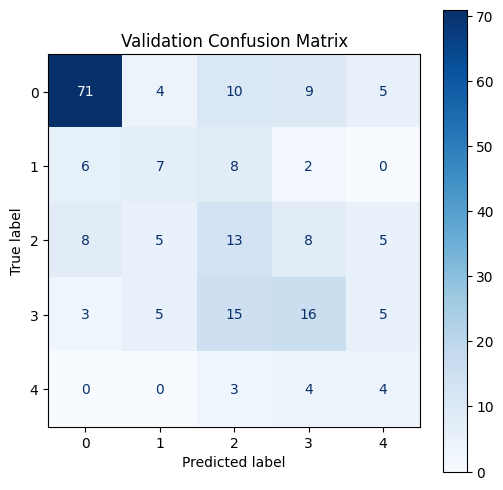

Confusion matrix raw:
[[71  4 10  9  5]
 [ 6  7  8  2  0]
 [ 8  5 13  8  5]
 [ 3  5 15 16  5]
 [ 0  0  3  4  4]]


In [7]:
np.random.seed(0)

X = images.reshape(len(images), -1) / 255.0
Y = labels.astype(int)

idx = np.random.permutation(len(X))
split = int(0.8 * len(X))

X_train, X_val = X[idx[:split]], X[idx[split:]]
Y_train, Y_val = Y[idx[:split]], Y[idx[split:]]

def oversample_and_augment(X, y, noise_std=0.01, scale_range=0.05, shift_std=0.01):
    """
    Oversample minority classes + apply simple numeric augmentations.
    Returns new_X, new_y (balanced).
    """

    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()

    new_X = []
    new_y = []

    for cls in classes:
        X_cls = X[y == cls]
        count = len(X_cls)

        # 1. Copy all original samples
        new_X.append(X_cls)
        new_y.append(np.full(count, cls))

        # 2. Oversample to match majority class
        needed = max_count - count
        if needed > 0:
            idx = np.random.choice(count, needed, replace=True)
            X_over = X_cls[idx]

            # 3. Apply numeric augmentations (optional but useful)
            noise = np.random.randn(*X_over.shape) * noise_std
            scale = 1 + (np.random.randn(X_over.shape[0], 1) * scale_range)
            shift = np.random.randn(*X_over.shape) * shift_std

            X_aug = X_over * scale + shift + noise

            new_X.append(X_aug)
            new_y.append(np.full(needed, cls))

    # Final dataset
    new_X = np.vstack(new_X)
    new_y = np.concatenate(new_y)

    # Shuffle before returning
    idx = np.random.permutation(len(new_y))
    return new_X[idx], new_y[idx]

Y_train = Y_train.flatten()
Y_val = Y_val.flatten()


X_train, Y_train = oversample_and_augment(X_train, Y_train)

lr = 0.01
num_epochs = 200
reg = 0.001

model = SimpleMLP(lr=lr, num_epochs=num_epochs, reg=reg)
model.fit(X_train, Y_train)

print("Validation accuracy:", model.accuracy(X_val, Y_val))
print("Training accuracy:", model.accuracy(X_train, Y_train))

Y_val_pred = model.predict(X_val)

cm = confusion_matrix(Y_val, Y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(Y_val))

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Confusion Matrix")
plt.savefig(f"figures/confusion_matrix_{model.name()}.png")
plt.show()

print("Confusion matrix raw:")
print(cm)


In [8]:
with open("data/test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

X_test = test_data["images"]

X_test = X_test.reshape(len(X_test), -1) / 255.0
y_pred = model.predict(X_test)

with open("submission.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "Label"])
    for i, label in enumerate(y_pred, start=1):
        writer.writerow([i, label])